#Multivariate Regression Agent

##Steps:
* Load Data (for now assumes pretty clean)
    * Drops na values
* Add constant for statsmodels
* Split into X and y
* Split into train test for X and y

##To Evaluate:
* Plot of coefficients with std error bars ordered by most important
* RSE / Adj R-Sq
* RSS Train and Test
* Correlation Matrix
    * VIF Score
* F-Stat
* Plot Residuals v Fitted <- Hetero and non-linear fit
* Predictions
* Scatter Plots
* Leverage v Studentized Residuals

##Think About:
* Adding interaction terms automatically
* Auto detect dummy variables
* Check to make sure p small enough for certain plots


In [11]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats import outliers_influence
from sklearn import cross_validation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from __future__ import division
%matplotlib inline
sns.set(style='ticks', palette='Set2')

small_data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original",
                   delim_whitespace = True, header=None,
                   names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
                            'model', 'origin', 'car_name'])
small_data = small_data.dropna()
small_X_features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']
small_y_feature = 'mpg'
small_X = small_data[small_X_features]
small_X = sm.add_constant(small_X)
small_y = small_data[small_y_feature]
sX_train, sX_test, sy_train, sy_test = cross_validation.train_test_split(small_X, small_y, test_size=0.3, random_state=0)
train_fit = sm.OLS(sy_train, sX_train).fit()

##Coefficient Plot

The idea is you can quickly see the most significant variables and how spread their confidence is. And their magnitude.

Different colors for significant parameters?

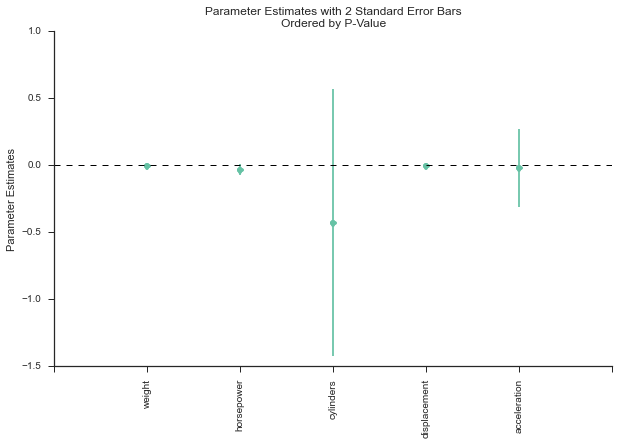

In [12]:
coef_df = pd.DataFrame()
coef_df['pvalues'] = train_fit.pvalues[1:]
coef_df['se2'] = train_fit.bse[1:] * 2
coef_df['params'] = train_fit.params[1:]
coef_df['names'] = small_X_features
coef_df = coef_df.sort('pvalues')
coef_df['x'] = np.arange(len(small_X_features)) + 1
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.errorbar(coef_df['x'], coef_df['params'], yerr=coef_df['se2'], fmt='o')
plt.axhline(0, linestyle='--', c='black', lw=1)
axes.set_xlim(0, len(small_X_features) + 1)
axes.set_xticklabels([""] + list(coef_df['names']) + [""], rotation='vertical')
axes.set_ylabel("Parameter Estimates")
axes.set_title("Parameter Estimates with 2 Standard Error Bars\nOrdered by P-Value")
sns.despine()

##CorrPlot

The idea here is if you care about inference, you want to try and handle correlated variables. Messes up parameter estimates, standard errors, and p-values. For prediction, doesn't mattter.

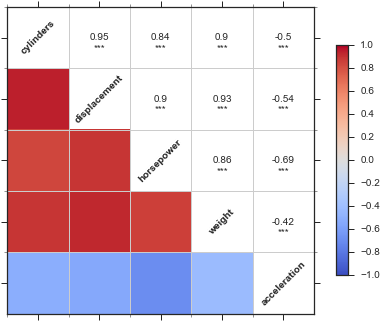

In [13]:
sns.corrplot(small_X.drop('const', 1))

##VIF

This allows you to see multicolinearity. If VIF > 5 have problems.

In [14]:
def get_vif(nparray, featurenames):
    vif = []
    for i, name in enumerate(featurenames):
        vif.append(outliers_influence.variance_inflation_factor(nparray, i))
    return zip(featurenames, vif)

In [15]:
get_vif(small_X.values, small_X_features)

[('cylinders', 154.86010964434956),
 ('displacement', 10.630870252969601),
 ('horsepower', 19.535060947488404),
 ('weight', 8.9160165667675191),
 ('acceleration', 10.430271127533111)]

##Outlier Plot

If Studentized Residuals > 3 might be outlier
Outlier => y value is strange give X values
Leverage => High X values relative to other X values
Size is cook's distance. Bigger means bigger effect when removing from regression.

Leverage points have more effect on OLS. If greater than (p+1) / n might have problem

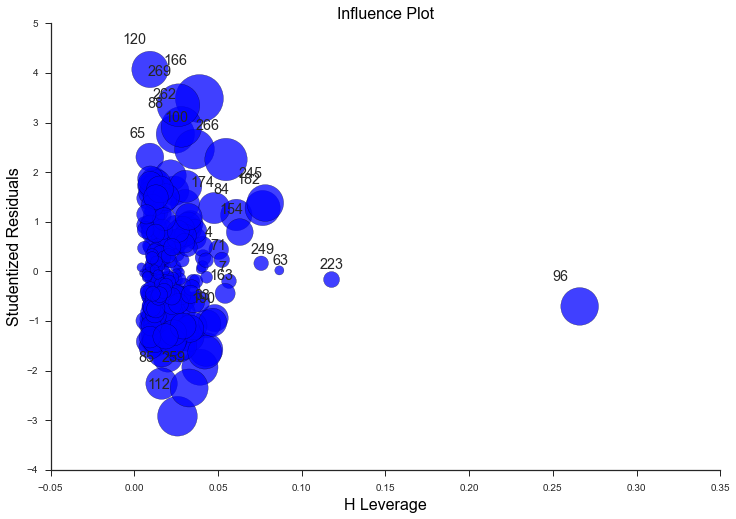

In [16]:
leverage_avg = (small_X.shape[1] + 1) / small_X.shape[0]
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(train_fit, ax=ax, criterion="cooks")
#ax.axhline(3, linestyle='--', c='black', lw=1)
#ax.axhline(-3, linestyle='--', c='black', lw=1)
#ax.axvline(leverage_avg, linestyle='--', c='black', lw=1)
sns.despine()

In [30]:
??sm.graphics.influence_plot()

In [47]:
infl = train_fit.get_influence()
#cooks
psize = infl.cooks_distance[0]
size=48
old_range = np.ptp(psize)
new_range = size**2 - 8**2
psize = (psize - psize.min()) * new_range/old_range + 8**2
#leverage
leverage = infl.hat_matrix_diag
#resids
resids = infl.resid_studentized_external
#labels
labels = range(len(resids))
#get avg lvg
data_shape = train_fit.model.data.exog.shape
#put in frame
outlier_data = pd.DataFrame()
outlier_data['stdres'] = resids
outlier_data['lvg'] = leverage
outlier_data['rownum'] = labels
outlier_data['cook'] = psize
outlier_data['lvg_avg'] = (data_shape[1] + 1) / data_shape[0]
outlier_data.to_csv("/Users/tylerfolkman/GradSchool/cogscale/plots/data.tsv", sep="\t", index=False)

##Residual Plots
Don't want to see funnel shape. Hetero. A solution. Take log of y

Don't want to see a pattern - implies our linear model has a problem. If pattern, maybe need some more features (polys) or maybe function just not linear.

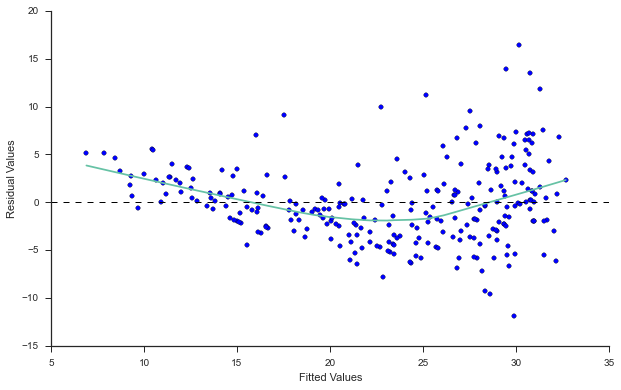

In [82]:
lowess = sm.nonparametric.lowess
z = lowess(train_fit.resid, train_fit.fittedvalues)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.scatter(train_fit.fittedvalues, train_fit.resid)
axes.plot(z[:,0], z[:,1])
axes.set_xlabel("Fitted Values")
axes.set_ylabel("Residual Values")
axes.axhline(0, linestyle='--', c='black', lw=1)
sns.despine()

##Numbers
F-Stat: Want it to be greater than 1 => a relationship

RMSE: Average squared residual, then root to get back into orig values

Adj-R: Can use to compare various linear regressions. Adjusts for change in p


In [83]:
f_stat = train_fit.fvalue
def get_mean_res(data, coef, actual):
    predictions = data.dot(coef)
    n = predictions.shape[0]
    mean_res = np.sqrt(np.sum((actual - predictions)**2) / n)
    return predictions, mean_res
test_predictions, test_rmse = get_mean_res(sX_test, train_fit.params, sy_test)
train_predictions, train_rmse = get_mean_res(sX_train, train_fit.params, sy_train)
adj_rsq = train_fit.rsquared_adj

In [84]:
test_rmse

4.4425943824212482

##Prediction Plots

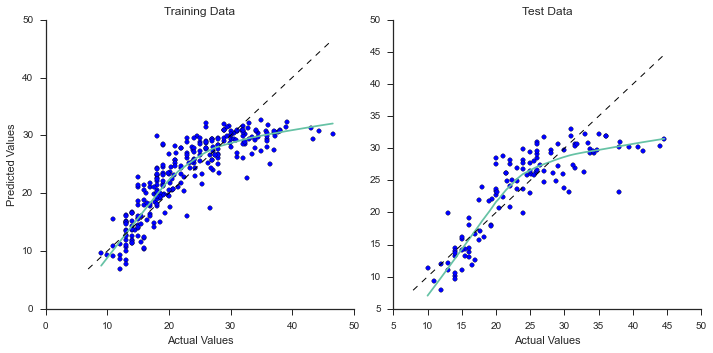

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

z_1 = lowess(train_predictions, sy_train)
z_2 = lowess(test_predictions, sy_test)
diag_line_1 = np.linspace(min(min(train_predictions), min(sy_train)), 
                          max(max(train_predictions), max(sy_train)), 100)
diag_line_2 = np.linspace(min(min(test_predictions), min(sy_test)), 
                          max(max(test_predictions), max(sy_test)), 100)

ax[0].scatter(sy_train, train_predictions)
ax[0].plot(z_1[:,0], z_1[:,1])
ax[0].plot(diag_line_1, diag_line_1, ls="--", c="black", lw=1)
ax[0].set_ylabel("Predicted Values")
ax[0].set_xlabel("Actual Values")
ax[0].set_title("Training Data")

ax[1].scatter(sy_test, test_predictions)
ax[1].plot(z_2[:,0], z_2[:,1])
ax[1].plot(diag_line_2, diag_line_2, ls="--", c="black", lw=1)
ax[1].set_xlabel("Actual Values")
ax[1].set_title("Test Data")

sns.despine()
plt.tight_layout()

##Scatter Plots

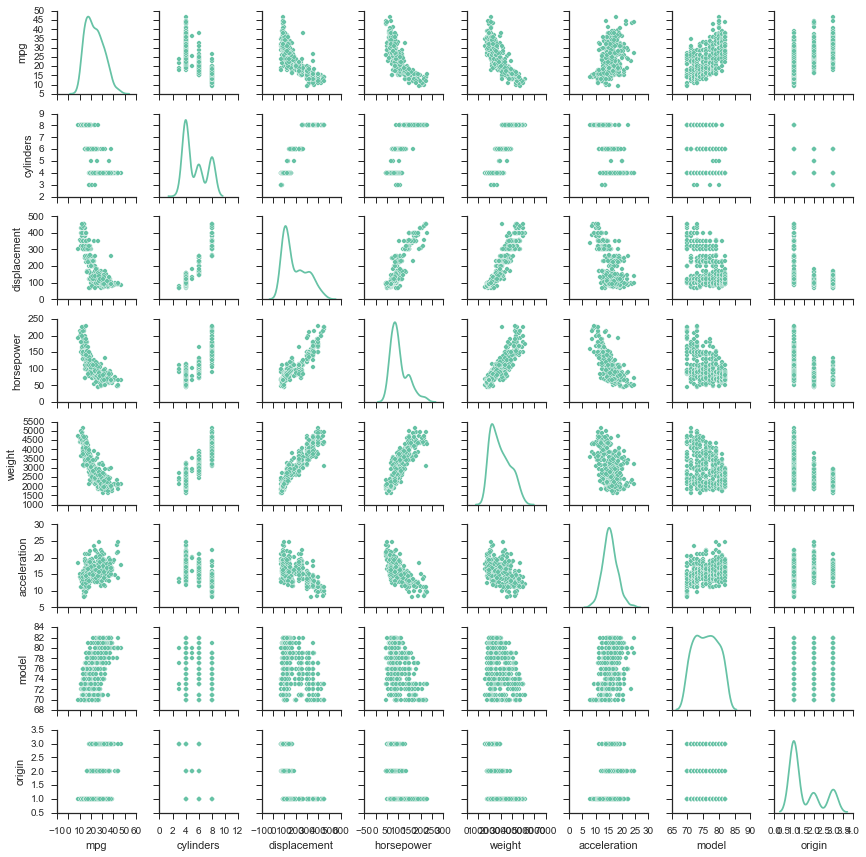

In [75]:
g = sns.pairplot(small_data, diag_kind="kde", size=1.5)